# Lie2Me

Detectar emociones en caras de clientes usando MobileNetV2 fine-tune y datasets públicos de expresiones faciales (FER, AffectNet).

En la industria hotelera, la gestión del feedback implica recopilar, analizar y usar opiniones (de encuestas y Booking) para mejorar la experiencia del cliente. La idea es analizar expresiones faciales para detectar emociones/sentimientos y ver si hay coherencia con las opiniones escritas.

## Preparar el entorno (Google Colab o local)

In [ ]:
# !pip install tensorflow opencv-python matplotlib pandas


## 1 Importar librerías

In [ ]:
import os
import shutil
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam



## 2 Descargar dataset FER2013

In [ ]:
path = kagglehub.dataset_download("msambare/fer2013")
print("Ruta dataset:", path)



Ruta dataset: /kaggle/input/fer2013


## 3 Inspeccionar estructura para ruta dataset original

In [ ]:
print("Contenido raíz:", os.listdir(path))
if 'train' in os.listdir(path):
    original_path = os.path.join(path, 'train')
else:
    original_path = path

print("Contenido original dataset:", os.listdir(original_path))



Contenido raíz: ['test', 'train']
Contenido original dataset: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


## 4 Crear micro-dataset binario

In [ ]:
binario_path = 'dataset_binario'
predispuesto = ['happy', 'neutral', 'surprise']
no_predispuesto = ['angry', 'sad', 'disgust', 'fear']

os.makedirs(binario_path, exist_ok=True)
os.makedirs(os.path.join(binario_path, 'predispuesto'), exist_ok=True)
os.makedirs(os.path.join(binario_path, 'no_predispuesto'), exist_ok=True)

print("Creando micro-dataset binario...")

for emotion in os.listdir(original_path):
    emotion_folder = os.path.join(original_path, emotion)
    if not os.path.isdir(emotion_folder):
        continue

    if emotion in predispuesto:
        target_folder = os.path.join(binario_path, 'predispuesto')
    elif emotion in no_predispuesto:
        target_folder = os.path.join(binario_path, 'no_predispuesto')
    else:
        print(f"Emoción ignorada: {emotion}")
        continue

    for filename in os.listdir(emotion_folder):
        src_file = os.path.join(emotion_folder, filename)
        dst_file = os.path.join(target_folder, filename)
        # Evitar sobrescribir si hay archivos con mismo nombre
        if not os.path.exists(dst_file):
            shutil.copy(src_file, dst_file)

print("Micro-dataset binario creado.")



Creando micro-dataset binario...
Micro-dataset binario creado.


## 5 Parámetros generales

In [ ]:
img_size = 224
batch_size = 32
epochs_head = 5
epochs_finetune = 3

## 6 Preparar generadores de datos con validación 20%

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Solo normalización para validación
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=binario_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=binario_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 22967 images belonging to 2 classes.
Found 5741 images belonging to 2 classes.


## 7 Cargar modelo base MobileNetV2 sin top

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Congelar para entrenar solo cabeza inicialmente



## 8 Construir modelo completo para salida binaria

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])



## 9 Compilar modelo

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])



## 10 Entrenar solo cabeza (capas nuevas)

In [ ]:
print("Entrenando solo la cabeza del modelo...")
model.fit(train_generator, validation_data=val_generator, epochs=epochs_head)



Entrenando solo la cabeza del modelo...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 287s 384ms/step - accuracy: 0.5645 - loss: 0.7449 - val_accuracy: 0.6239 - val_loss: 0.6477
Epoch 2/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 263s 367ms/step - accuracy: 0.6184 - loss: 0.6522 - val_accuracy: 0.6417 - val_loss: 0.6351
Epoch 3/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 264s 368ms/step - accuracy: 0.6297 - loss: 0.6439 - val_accuracy: 0.6408 - val_loss: 0.6361
Epoch 4/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 274s 382ms/step - accuracy: 0.6373 - loss: 0.6363 - val_accuracy: 0.6537 - val_loss: 0.6225
Epoch 5/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 265s 370ms/step - accuracy: 0.6479 - loss: 0.6324 - val_accuracy: 0.6541 - val_loss: 0.6213


# 11 Descongelar base para fine-tuning

In [ ]:
print("Descongelando base_model para fine-tuning...")
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=epochs_finetune)



Descongelando base_model para fine-tuning...
Epoch 1/3
718/718 ━━━━━━━━━━━━━━━━━━━━ 366s 440ms/step - accuracy: 0.5854 - loss: 0.6730 - val_accuracy: 0.6626 - val_loss: 0.6119
Epoch 2/3
718/718 ━━━━━━━━━━━━━━━━━━━━ 291s 405ms/step - accuracy: 0.6710 - loss: 0.6058 - val_accuracy: 0.6821 - val_loss: 0.5858
Epoch 3/3
718/718 ━━━━━━━━━━━━━━━━━━━━ 294s 409ms/step - accuracy: 0.7070 - loss: 0.5644 - val_accuracy: 0.7027 - val_loss: 0.5636


## 12 Guardar modelo final

In [ ]:
model.save("mobilenetv2_emotion_binario_finetune.h5")
print("Modelo guardado como mobilenetv2_emotion_binario_finetune.h5")


Modelo guardado como mobilenetv2_emotion_binario_finetune.h5


## Descargar el modelo a tu ordenador

In [ ]:
from google.colab import files
files.download("mobilenetv2_emotion_binario_finetune.h5")


## 13 Subir una imagen y hacer la predicción con el modelo entrenado

Saving mi_foto.jpg to mi_foto (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


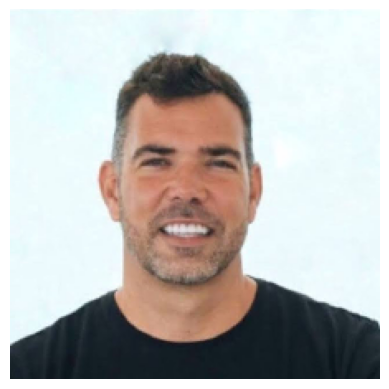

Predicción: Predispuesto a repetir con probabilidad 0.65


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Cargar modelo entrenado
model = tf.keras.models.load_model("mobilenetv2_emotion_binario_finetune.h5")

# Función para preprocesar imagen
def preprocess_img(img_path, img_size=224):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimension
    return img, img_array

# Subir imagen
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    # Preprocesar
    img, img_array = preprocess_img(img_path)

    # Predecir
    pred = model.predict(img_array)[0][0]

    # Mostrar imagen y resultado
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Umbral clásico 0.5 para binaria
    if pred > 0.5:
        print(f"Predicción: Predispuesto a repetir con probabilidad {pred:.2f}")
    else:
        print(f"Predicción: No predispuesto a repetir con probabilidad {1-pred:.2f}")


## Subir un vídeo y hacer la predicción con el modelo entrenado

Saving mi_video_1.MOV to mi_video_1 (1).MOV
Video cargado: mi_video_1 (1).MOV
FPS: 30.0, Total frames: 197, Duración: 6.57 segundos
Analizando 150 frames (~5 segundos)


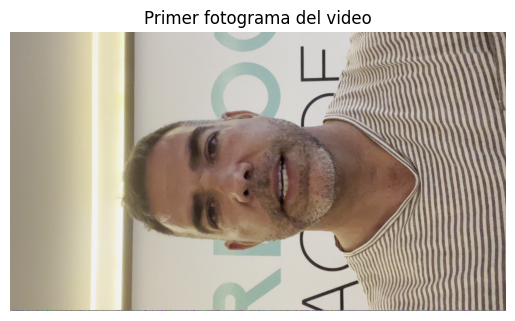

Frames predispuestos a repetir: 138
Frames no predispuestos a repetir: 12

Predicción final: ✅ Predispuesto a repetir (basado en mayoría de frames)


In [ ]:
!pip install opencv-python

import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import tensorflow as tf

# Cargar modelo entrenado
model = tf.keras.models.load_model("mobilenetv2_emotion_binario_finetune.h5")

# Parámetros
img_size = 224
seconds_to_analyze = 5

# Subir video
uploaded_video = files.upload()
video_filename = list(uploaded_video.keys())[0]
print(f"Video cargado: {video_filename}")

# Abrir video con OpenCV
cap = cv2.VideoCapture(video_filename)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration_seconds = total_frames / fps
print(f"FPS: {fps}, Total frames: {total_frames}, Duración: {duration_seconds:.2f} segundos")

max_frame = min(int(fps * seconds_to_analyze), total_frames)
print(f"Analizando {max_frame} frames (~{seconds_to_analyze} segundos)")

predictions = []

for frame_idx in range(max_frame):
    ret, frame = cap.read()
    if not ret:
        print("No se pudo leer más frames")
        break

    # Convertir BGR a RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Mostrar el primer frame para referencia
    if frame_idx == 0:
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title("Primer fotograma del video")
        plt.show()

    # Preprocesar imagen para modelo
    frame_resized = cv2.resize(frame_rgb, (img_size, img_size))
    img_array = np.expand_dims(frame_resized / 255.0, axis=0)

    # Predecir (valor entre 0 y 1)
    pred = model.predict(img_array, verbose=0)[0][0]
    predictions.append(pred)

cap.release()

# Contar cuántos frames predicen predisposición > 0.5
count_positive = sum(p > 0.5 for p in predictions)
count_negative = len(predictions) - count_positive

print(f"Frames predispuestos a repetir: {count_positive}")
print(f"Frames no predispuestos a repetir: {count_negative}")

if count_positive > count_negative:
    print(f"\nPredicción final: Predispuesto a repetir (basado en mayoría de frames)")
else:
    print(f"\nPredicción final: No predispuesto a repetir (basado en mayoría de frames)")
